In [1]:
import numpy as np
import matplotlib.pyplot as plt

from simple_tritium_transport_model import Model, ureg, quantity_to_activity


## Model definition

$$ V \frac{d c_\mathrm{salt}}{dt} = S - Q_\mathrm{wall} - Q_\mathrm{top} $$

$$ S = \mathrm{TBR} \cdot \Gamma_n $$
where $\Gamma_n$ is the neutron rate in n/s.
$\mathrm{TBR}$ is assumed to evolve proportionally to the radius (see Figure 7 of [LIBRA paper](https://www.tandfonline.com/doi/full/10.1080/15361055.2022.2078136)) with $ \mathrm{TBR}(r= 7 \mathrm{cm}) = 0.01 $.

$Q_i$ are the release rate of T permeating through the walls and being released at the top of the salt and are expressed as:
$$ Q_i = A_i \ k_i \ (c_\mathrm{salt} - c_\mathrm{external}) \approx A_i \ k_i \ c_\mathrm{salt}$$
where $A_i$ is the contact surface area, $k_i$ are the mass transfer coefficients.

In [2]:
class ScaledModel(Model):
    def __init__(self, radius) -> None:
        self.radius = radius
        super().__init__(radius=radius, height=self.compute_height(), TBR=self.compute_TBR())

    def compute_height(self):
        # BABY standard geometry
        volume = 1 * ureg.L
        radius = 7 * ureg.cm
        cross_section = np.pi * radius**2
        height = volume / cross_section
        height_to_radius_ratio = height / radius
        return height_to_radius_ratio * self.radius
    
    def compute_TBR(self):
        ratio = 0.01 * ureg.particle * ureg.neutron**-1 / (7 * ureg.cm)
        return ratio * self.radius



## Standard BABY run

In [3]:
baby_radius = 7 * ureg.cm
baby_volume = 1 * ureg.L
baby_cross_section = np.pi * baby_radius**2
baby_height = baby_volume / baby_cross_section
baby_model = Model(
    radius=baby_radius,
    height=baby_height,
    TBR=1.2e-3 * ureg.particle * ureg.neutron**-1,
)

baby_model.exposure_time = 10 * ureg.hour
baby_model.dt = 0.5 * ureg.h
baby_model.run(6 * ureg.day)


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:222: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:237: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_quadrature.py:353: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_quadrature.py:357: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)


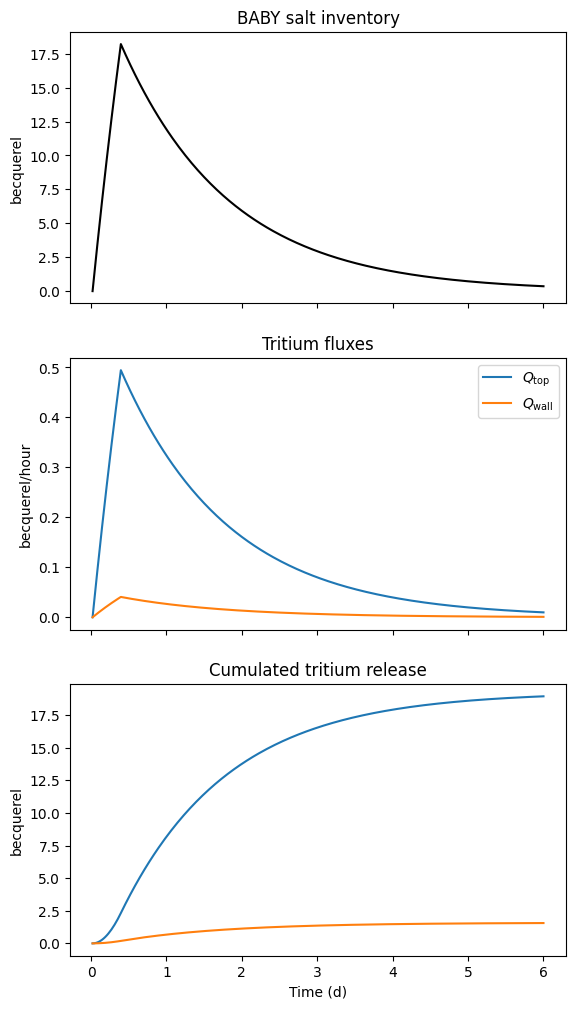

In [4]:
from scipy.integrate import cumulative_trapezoid

time = baby_model.times.to(ureg.day)

fig, (ax_inv, ax_fluxes, ax_cumul) = plt.subplots(3, 1, sharex=True, figsize=(6.4, 12))
plt.sca(ax_inv)
plt.title("BABY salt inventory")
plt.plot(
    time,
    quantity_to_activity(baby_model.concentrations * baby_model.volume).to(ureg.Bq),
    color="black",
)

plt.sca(ax_fluxes)
plt.title("Tritium fluxes")
release_top = quantity_to_activity(baby_model.Q_top(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_top = release_top.to(ureg.Bq * ureg.h**-1)
release_walls = quantity_to_activity(baby_model.Q_wall(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_walls = release_walls.to(ureg.Bq * ureg.h**-1)
plt.plot(time, release_top, label="$Q_\mathrm{top}$")
plt.plot(time, release_walls, label="$Q_\mathrm{wall}$")
plt.legend()

plt.sca(ax_cumul)
plt.title("Cumulated tritium release")
integrated_top = (
    cumulative_trapezoid(
        release_top.to(ureg.Bq * ureg.h**-1), time.to(ureg.h), initial=0
    )
    * ureg.Bq
)
integrated_wall = (
    cumulative_trapezoid(
        release_walls.to(ureg.Bq * ureg.h**-1), time.to(ureg.h), initial=0
    )
    * ureg.Bq
)
plt.plot(time, integrated_top, label="top")
plt.plot(time, integrated_wall, label="wall")
plt.xlabel(f"Time ({time.units:~P})")
plt.show()


## Varying exposure time

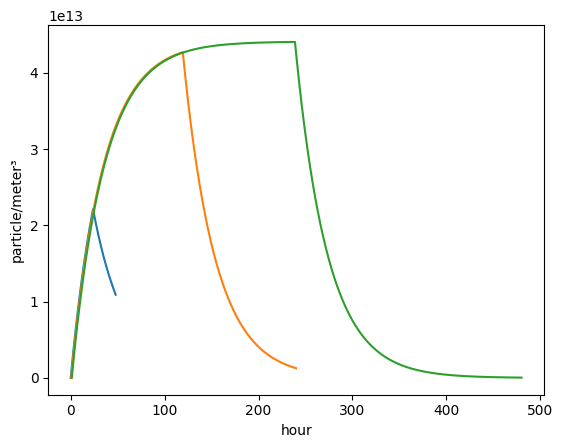

In [5]:
times = [1, 5, 10] * ureg.days
models = []

for time in times:
    baby_model.reset()
    baby_model.exposure_time = time
    models.append(baby_model)
    baby_model.dt = time/200
    baby_model.run(baby_model.exposure_time * 2)

    times = baby_model.times.to(ureg.h)
    plt.plot(times, baby_model.concentrations)

## Varying the volume of salt

This is a parametric study trying to investigate the potential advantages of reducing the salt volume.
In this study, the irradiation is stopped after 300h

In [6]:
radius_values = [1, 2, 3, 4, 5, 6, 7] * ureg.cm
models = []

for radius in radius_values:
    my_model = ScaledModel(radius=radius)
    models.append(my_model)

    my_model.run(my_model.exposure_time * 2)


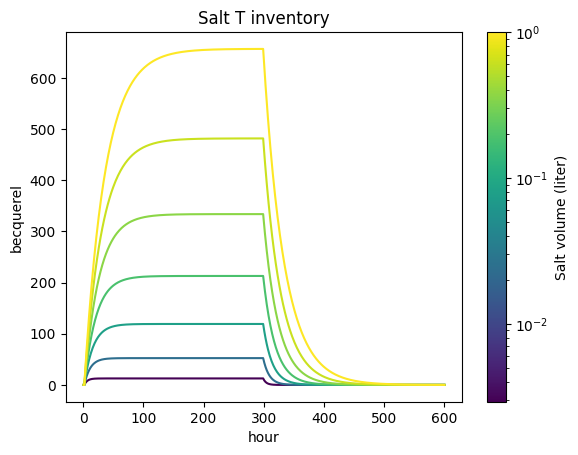

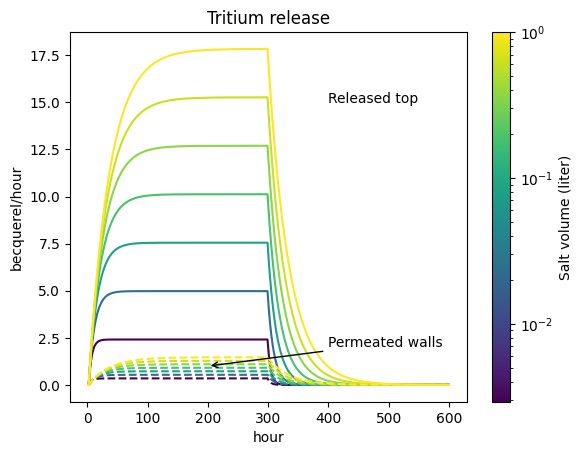

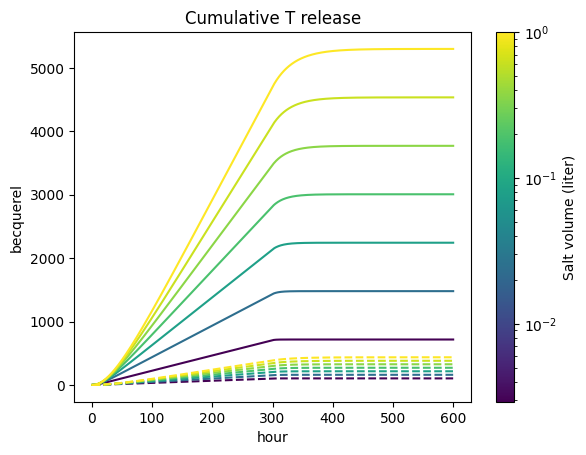

In [7]:
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm

volume_values = [model.volume for model in models]
volume_values = ureg.Quantity.from_list(volume_values)
norm_V_salt = LogNorm()
norm_V_salt.autoscale(volume_values.magnitude)


for model in models:
    times = model.times.to(ureg.h)
    colour = cm.viridis(norm_V_salt(model.volume.magnitude))

    # plot inventory
    plt.figure(1)
    inventory = quantity_to_activity(model.volume * model.concentrations)
    plt.plot(times, inventory.to(ureg.Bq), color=colour)

    # plot fluxes
    plt.figure(2)
    top_release = quantity_to_activity(model.Q_top(model.concentrations))
    top_release = top_release.to(ureg.Bq * ureg.h**-1)
    wall_release = quantity_to_activity(model.Q_wall(model.concentrations))
    wall_release = wall_release.to(ureg.Bq * ureg.h**-1)
    plt.plot(times, top_release, color=colour)
    plt.plot(times, wall_release, linestyle="dashed", color=colour)

    # plot integrated release
    plt.figure(3)
    integrated_top = (
        cumulative_trapezoid(
            top_release.to(ureg.Bq * ureg.h**-1), times.to(ureg.h), initial=0
        )
        * ureg.Bq
    )
    integrated_wall = (
        cumulative_trapezoid(
            wall_release.to(ureg.Bq * ureg.h**-1), times.to(ureg.h), initial=0
        )
        * ureg.Bq
    )
    plt.plot(times, integrated_top, color=colour)
    plt.plot(times, integrated_wall, linestyle="dashed", color=colour)

sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm_V_salt)

plt.figure(1)
plt.title("Salt T inventory")
plt.colorbar(sm, ax=plt.gca(), label=f"Salt volume ({model.volume.units})")
plt.figure(2)
plt.title("Tritium release")
plt.annotate("Released top", (400 * ureg.h, 15 * ureg.Bq * ureg.h**-1))
plt.annotate(
    "Permeated walls",
    (200 * ureg.h, 1 * ureg.Bq * ureg.h**-1),
    (400 * ureg.h, 2 * ureg.Bq * ureg.h**-1),
    arrowprops=dict(facecolor="black", arrowstyle="->"),
)
plt.colorbar(sm, ax=plt.gca(), label=f"Salt volume ({model.volume.units})")
plt.figure(3)
plt.title("Cumulative T release")
plt.colorbar(sm, ax=plt.gca(), label=f"Salt volume ({model.volume.units})")

plt.show()


## Can we detect tritium in the sweep gas?

This section tries to determine if we can detect T in the sweep gas for a 1L salt volume experiment.

In [8]:
baby_model.neutron_rate = 1e8 * ureg.neutron * ureg.s**-1
baby_model.exposure_time = 10 * ureg.h
baby_model.dt = baby_model.exposure_time/10
print(f"Salt volume: {baby_model.volume.to(ureg.mL):.2f~P}")
print(f"TBR: {baby_model.TBR.to(ureg.dimensionless):.4f~P}")

baby_model.reset()
baby_model.run(t_final=8*ureg.day)

Salt volume: 1000.00 ml
TBR: 0.0012


The concentration of T in the sweep gas can be computed by:

$$ c_\mathrm{T,i} = \frac{Q_\mathrm{i}}{\Gamma_\mathrm{i}} $$

- $\mathrm{i} = {\mathrm{top},\ \mathrm{walls}}$
- $Q$: release rate
- $\Gamma$: sweep gas flow rate

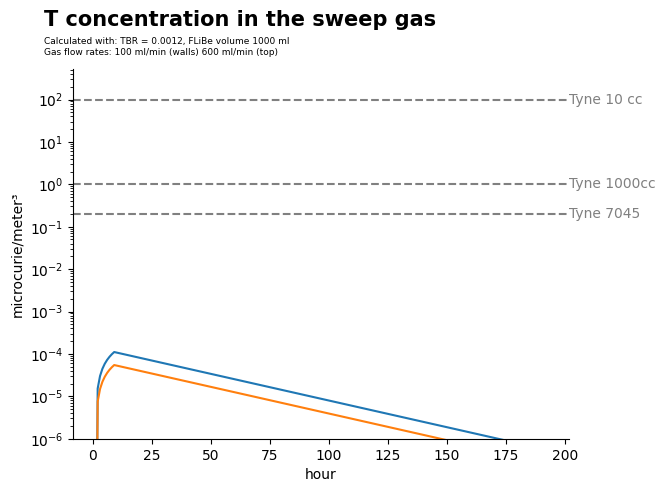

In [9]:
wall_release = quantity_to_activity(baby_model.Q_wall(baby_model.concentrations))
top_release = quantity_to_activity(baby_model.Q_top(baby_model.concentrations))
flow_rate_wall = 100 * ureg.mL * ureg.min**-1
flow_rate_top = 600 * ureg.mL * ureg.min**-1

wall_sweep_concentration = wall_release / flow_rate_wall
top_sweep_concentration = top_release / flow_rate_top

plt.gcf().text(0.08, 0.97, "T concentration in the sweep gas", weight="bold", fontsize=15)
subtitle = [
    f"Calculated with: TBR = {baby_model.TBR.to(ureg.dimensionless):.4f~P}, FLiBe volume {baby_model.volume.to(ureg.ml):.0f~P}",
    f"Gas flow rates: {flow_rate_wall:.0f~P} (walls) {flow_rate_top:.0f~P} (top)",
]

plt.gcf().text(0.08, 0.91, s="\n".join(subtitle), fontsize=6.5)

tyne_1000_cc_ion_chamber = (
    1 * ureg.microcurie * ureg.m**-3
)  # http://www.tyne-engineering.com/1000%20cc%20Ion%20Chamber.html
tyne_10_cc_ion_chamber = (
    100 * ureg.microcurie * ureg.m**-3
)  # http://www.tyne-engineering.com/10%20cc%20Ion%20Chamber.html
tyne_7045_ion_chamber = (
    0.2 * ureg.microcurie * ureg.m**-3
)  # https://tyneusa.com/tritium-monitor-7045

l1 = plt.axhline(
    tyne_1000_cc_ion_chamber, color="grey", linestyle="dashed", label="Tyne 1000cc"
)
l2 = plt.axhline(
    tyne_10_cc_ion_chamber, color="grey", linestyle="dashed", label="Tyne 10 cc"
)
l3 = plt.axhline(
    tyne_7045_ion_chamber, color="grey", linestyle="dashed", label="Tyne 7045"
)


l4, = plt.plot(
    baby_model.times.to(ureg.h),
    top_sweep_concentration.to(ureg.Bq * ureg.m**-3),
    label="Top release",
)
l5, = plt.plot(
    baby_model.times.to(ureg.h),
    wall_sweep_concentration.to(ureg.Bq * ureg.m**-3),
    label="Permeated",
)

plt.yscale("log")
plt.ylim(bottom=1e-6)

for l in [l1, l2, l3]:
    plt.annotate(
        l.get_label(),
        xy=(l.get_xdata()[1] * plt.gca().get_xlim()[-1], l.get_ydata()[1]),
        va="center",
        color=l.get_color(),
    )

for l in [l4, l5]:
    plt.annotate(
        l.get_label(),
        xy=(l.get_xdata()[-1], l.get_ydata()[-1]),
        va="center",
        color=l.get_color(),
    )
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)

The bubblers + liquid scintillation counting system measures the total quantity of tritium released over time.

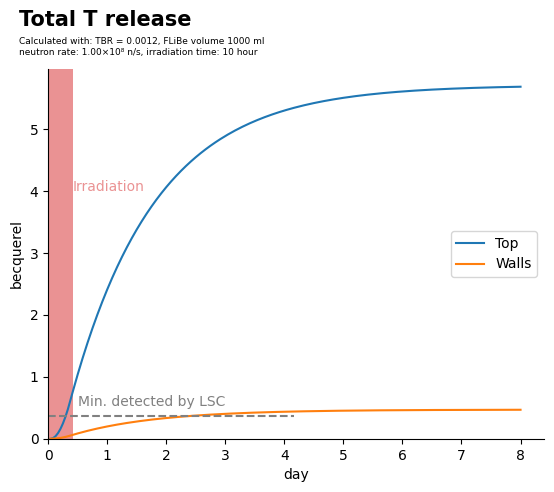

In [10]:
plt.gca().xaxis.set_units(ureg.day)

plt.gcf().text(0.08, 0.97, "Total T release", weight="bold", fontsize=15)
subtitle = [
    f"Calculated with: TBR = {baby_model.TBR.to(ureg.dimensionless):.4f~P}, FLiBe volume {baby_model.volume.to(ureg.ml):.0f~P}",
    f"neutron rate: {baby_model.neutron_rate:.2e~P}, irradiation time: {baby_model.exposure_time}"
]

plt.gcf().text(0.08, 0.91, s="\n".join(subtitle), fontsize=6.5)


integrated_top = (
    cumulative_trapezoid(
        top_release.to(ureg.Bq * ureg.h**-1), baby_model.times.to(ureg.h), initial=0
    )
    * ureg.Bq
)
integrated_wall = (
    cumulative_trapezoid(
        wall_release.to(ureg.Bq * ureg.h**-1), baby_model.times.to(ureg.h), initial=0
    )
    * ureg.Bq
)
plt.plot(baby_model.times.to(ureg.h), integrated_top, label="Top")
plt.plot(baby_model.times.to(ureg.h), integrated_wall, label="Walls")
plt.legend()


minimum_act_detecable_LSC = 2 * ureg.pCi
LSC_sample_volume = 2 * ureg.ml
minimum_conc_detecable_LSC = minimum_act_detecable_LSC/LSC_sample_volume
vial_volume = 10 *ureg.ml

l = plt.hlines(vial_volume * minimum_conc_detecable_LSC, xmin=0*ureg.h, xmax=100*ureg.h, linestyle="dashed", color="grey", label="Min. detected by LSC")

plt.annotate(
    l.get_label(),
    xy=(12*ureg.h, 0.6*ureg.Bq),
    va="center",
    color="grey",
)

plt.axvspan(0*ureg.h, baby_model.exposure_time, facecolor='tab:red', alpha=0.5)
plt.annotate("Irradiation", (baby_model.exposure_time, 4*ureg.Bq), color="tab:red", alpha=0.5)

plt.xlim(left=0*ureg.h)
plt.ylim(bottom=0*ureg.Bq)
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)

## Influence of the wall on the global mass transport coefficient

We now try to derive an analytical expression for the mass transport coefficient of T from the salt bulk to the metallic wall.

- $Q$ the overall tritium permeation flux from the salt to the sweep gas
- $k_\mathrm{salt}$ the mass transport coefficient from the salt bulk to the metallic wall
- $A$ the surface area of the salt-metal interface
- $e$ metal thickness
- $c_\mathrm{salt}$ bulk salt concentration
- $c_\mathrm{S, int}$ salt concentration at the salt-metal interface
- $c_\mathrm{M, int}$ metal concentration at the salt-metal interface
- $D_\mathrm{M}$ metal diffusivity
- $K_\mathrm{M}$ metal solubility
- $D_\mathrm{S}$ salt diffusivity

In [11]:
import sympy as sp

Q = sp.Symbol("Q")
k = sp.Symbol("k_\mathrm{salt}")
A = sp.Symbol("A")
c_salt = sp.Symbol("c_\mathrm{salt}")
c_sint = sp.Symbol("c_\mathrm{S, int}")
c_mint = sp.Symbol("c_\mathrm{M, int}")
e = sp.Symbol("e")
D_M = sp.Symbol("D_\mathrm{M}")
K_M = sp.Symbol("K_\mathrm{M}")
K_S = sp.Symbol("K_\mathrm{S}")

The flux from the salt bulk to the salt-metal interface can be expressed as:

In [12]:
flux_salt_to_interface = sp.Eq(Q, k*A * (c_salt - c_sint))
flux_salt_to_interface

Eq(Q, A*k_\mathrm{salt}*(-c_\mathrm{S, int} + c_\mathrm{salt}))

Assuming the concentration at the metal-gas interface is zero, the flux through the metal layer is:

In [13]:
flux_interface_to_gas = sp.Eq(Q, A * D_M * c_mint / e)
flux_interface_to_gas

Eq(Q, A*D_\mathrm{M}*c_\mathrm{M, int}/e)

At the salt-metal interface, the conservation of chemical potential gives:

In [14]:
conservation_chemical_pot_interface = sp.Eq((c_sint/K_S), (c_mint/K_M)**2)
conservation_chemical_pot_interface

Eq(c_\mathrm{S, int}/K_\mathrm{S}, c_\mathrm{M, int}**2/K_\mathrm{M}**2)

Solving these three equations for $k$, $c_\mathrm{S, int}$, and $c_\mathrm{M, int}$, we can express $k_\mathrm{salt}$:

In [15]:
res = sp.solve(
    [
        flux_salt_to_interface,
        flux_interface_to_gas,
        conservation_chemical_pot_interface,
    ],
    [k, c_mint, c_sint],
    dict=True,
)

k_bis = 1/sp.expand(1/res[0][k])

k_definition = sp.Eq(k, k_bis)
k_definition

Eq(k_\mathrm{salt}, 1/(A*c_\mathrm{salt}/Q - K_\mathrm{S}*Q*e**2/(A*D_\mathrm{M}**2*K_\mathrm{M}**2)))

When $\frac{Q K_\mathrm{S} e^{2}}{A D_\mathrm{M}^{2} K_\mathrm{M}^{2}} \ll \frac{A c_\mathrm{salt}}{Q}$, or $W = \frac{Q^2 K_\mathrm{S} e^{2}}{c_\mathrm{salt} A^2 D_\mathrm{M}^{2} K_\mathrm{M}^{2}} \ll 1$

$$k_\mathrm{salt} \approx \frac{Q}{A c_\mathrm{salt}} = k_\mathrm{eq}$$

$W$ can be interpreted as $1 - k_\mathrm{eq}/k_\mathrm{salt}$

Here, $k_\mathrm{eq}$ is the mass transport coefficient from the bulk salt to the sweep gas.

This also implies $c_\mathrm{S, int} \ll c_\mathrm{salt}$.

Let's verify this approximation with the BABY model.

In [16]:
baby_model.reset()
baby_model.run(200 * ureg.h)

c_salt = baby_model.concentrations[-1]
Q = baby_model.Q_wall(c_salt)
A = baby_model.A_wall
e = baby_model.L_wall

# properties (OoM) for Inconel 600, Tungsten, and FLiBe at 700K
D_M_inconel = 1e-10 * ureg.m**2 * ureg.s**-1
K_M_inconel = 1e22 * ureg.particle * ureg.m**-3 * ureg.Pa**-0.5
D_M_tungsten = 1e-10 * ureg.m**2 * ureg.s**-1
K_M_tungsten = 1e20 * ureg.particle * ureg.m**-3 * ureg.Pa**-0.5

K_S = 1e19* ureg.particle * ureg.m**-3 * ureg.Pa**-1

number_inconel = Q**2*K_S*e**2/(A**2*c_salt*D_M_inconel**2*K_M_inconel**2)
number_tungsten = Q**2*K_S*e**2/(A**2*c_salt*D_M_tungsten**2*K_M_tungsten**2)

number_inconel = number_inconel.to(ureg.dimensionless)
number_tungsten = number_tungsten.to(ureg.dimensionless)

print(f"Inconel wall: W={number_inconel:.2e~P}")
print(f"Tungsten wall: W={number_tungsten:.2e~P}")

C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:222: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:237: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Inconel wall: W=4.34×10⁻¹⁵
Tungsten wall: W=4.34×10⁻¹¹


The assumption is valid and we can safely neglect the contribution of the wall to the overall mass transport resistance.

Note: the uncertainty associated with the salt solubility doesn't invalidate the assumption since the ratio would still be orders of magnitude lower than unity.

# Conclusions

- This model can describe the tritium transport dynamics in BABY (and LIBRA)
- The resistance of the metal wall (Inconel or Tungsten) to the mass transfer is negligible